<a href="https://colab.research.google.com/github/Bharasaurus/Netflix-Recommendation-System/blob/main/Netflix_Recommendation_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Netflix Recommendation Project -

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
netflix_dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Netflix_Datasets/Data.txt',header = None, names = ['Customer_Id', 'Rating'], usecols = [0,1])
netflix_dataset.head()
#netflix_dataset.info()
#netflix_dataset.shape

,Customer_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


In [3]:
rating=netflix_dataset.groupby(['Rating'])['Rating'].count()
rating=pd.DataFrame(rating)
rating=rating.rename(columns={'Rating':'Count'})
rating=rating.sort_values(by='Rating',ascending=0)
rating

,Count
Rating,
5.0,5506583
4.0,8085741
3.0,6904181
2.0,2439073
1.0,1118186


In [4]:
Movie_Count=netflix_dataset.isnull().sum()
Movie_Count=Movie_Count[1] #Number of Movies in the Dataset
Customer_Count=netflix_dataset['Customer_Id'].nunique()
Customer_Count=Customer_Count-Movie_Count #Number of Customers that Rated the Movies
Rating_Count=netflix_dataset['Customer_Id'].count()
Rating_Count=Rating_Count-Movie_Count #Number of Ratings

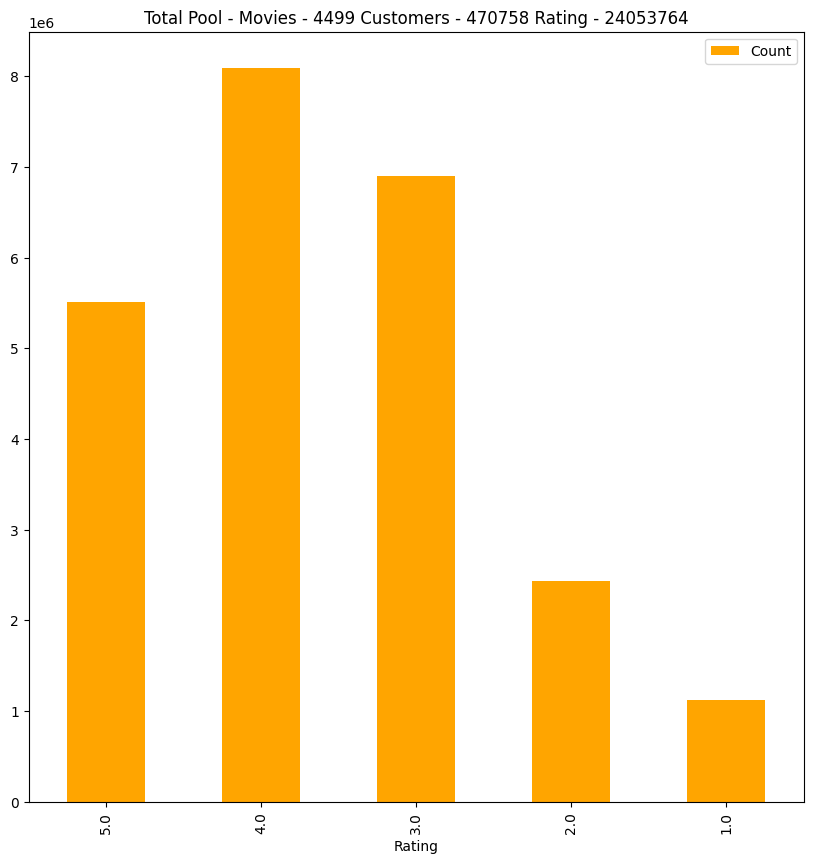

In [5]:
ax=rating.plot(kind='bar', legend=1, figsize=(10,10), color='orange')
plt.title(f'Total Pool - Movies - {Movie_Count} Customers - {Customer_Count} Rating - {Rating_Count}', fontsize=12)
plt.grid(False)

In [6]:
pd.options.mode.chained_assignment = None
Movies=pd.DataFrame(pd.isnull(netflix_dataset['Rating']))
Movies_ID=Movies[Movies['Rating']==1]
Movies_ID=Movies_ID.reset_index(drop=False)
Movie_List=[]
ID=1
for i, j in zip(Movies_ID['index'][1:], Movies_ID['index'][:-1]):
    temp=np.full((1, i-j-1), ID)
    Movie_List=np.append(Movie_List, temp)
    ID+=1

#For Last Record
Last_Record=np.full((1, len(netflix_dataset)-Movies_ID.iloc[-1,0]-1), ID)
Movie_List=np.append(Movie_List, Last_Record)
netflix_dataset=netflix_dataset[pd.notnull(netflix_dataset['Rating'])]
netflix_dataset['Movie_Id']=Movie_List.astype(int)
netflix_dataset['Customer_Id']=netflix_dataset['Customer_Id'].astype(int)

In [7]:
#Final Dataset
netflix_dataset.head(5)

,Customer_Id,Rating,Movie_Id
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1


In [8]:
#Data Cleaning (EDA Performed)
dataset_movie_summary=netflix_dataset.groupby('Movie_Id')['Rating'].agg(['count','mean'])
dataset_movie_summary.index=dataset_movie_summary.index.map(int)
dataset_movie_summary.head(5)

,count,mean
Movie_Id,,
1,547,3.749543
2,145,3.558621
3,2012,3.641153
4,142,2.739437
5,1140,3.919298


In [9]:
movie_benchmark=round(dataset_movie_summary['count'].quantile(0.7),0)
movie_benchmark #Benchmark == 1944
#Removing Movies with a lot of Rating
drop_movie_list=dataset_movie_summary[dataset_movie_summary['count']<movie_benchmark].index
drop_movie_list

Int64Index([   1,    2,    4,    5,    6,    7,    9,   10,   11,   12,
            ...
            4484, 4486, 4487, 4489, 4491, 4494, 4495, 4497, 4498, 4499],
           dtype='int64', name='Movie_Id', length=3149)

In [10]:
dataset_cust_summary=netflix_dataset.groupby('Customer_Id')['Rating'].agg(['count','mean'])
dataset_cust_summary
#Removing Movies with Inactive Customers
dataset_cust_summary.index=dataset_cust_summary.index.map(int)
cust_benchmark=round(dataset_cust_summary['count'].quantile(0.7),0) #Benchmark == 7
drop_cust_list=dataset_cust_summary[dataset_cust_summary['count']<cust_benchmark].index

In [11]:
#Shape of the DataFrame
print(f'The Original DataFrame Shape - {netflix_dataset.shape}')
netflix_dataset=netflix_dataset[~netflix_dataset['Movie_Id'].isin(drop_movie_list)]
netflix_dataset=netflix_dataset[~netflix_dataset['Customer_Id'].isin(drop_cust_list)]
print(f'The DataFrame Shape After Trimming - {netflix_dataset.shape}')
netflix_dataset.head(5)

The Original DataFrame Shape - (24053764, 3)
The DataFrame Shape After Trimming - (17337458, 3)


,Customer_Id,Rating,Movie_Id
696,712664,5.0,3
697,1331154,4.0,3
698,2632461,3.0,3
699,44937,5.0,3
700,656399,4.0,3


In [12]:
df_p = pd.pivot_table(netflix_dataset, values='Rating', index='Customer_Id', columns='Movie_Id')
df_title=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Netflix_Datasets/Movie_Name.csv', encoding='ISO-8859-1', header=None, usecols=[0,1,2], names=['Movie_Id','Year','Name' ])
df_title.set_index('Movie_Id', inplace=True)
df_title.head(5)

,Year,Name
Movie_Id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


In [13]:
import math
import re
from scipy.sparse import csr_matrix
import seaborn as sns
!pip install surprise
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

In [14]:
reader=Reader() #Required for SVD Algorithm to read the dataset
data=Dataset.load_from_df(netflix_dataset[['Customer_Id','Movie_Id','Rating']][:100000], reader)
svd=SVD()
cross_validate(svd, data, measures=['RMSE','MAE'], cv=3, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9917  1.0004  0.9986  0.9969  0.0037  
MAE (testset)     0.7977  0.8068  0.8032  0.8026  0.0037  
Fit time          2.31    2.08    1.40    1.93    0.39    
Test time         0.33    0.32    0.41    0.35    0.04    


{'test_rmse': array([0.9917251 , 1.00035617, 0.99859098]),
 'test_mae': array([0.79771697, 0.8067886 , 0.8031926 ]),
 'fit_time': (2.3149020671844482, 2.075282335281372, 1.396263837814331),
 'test_time': (0.32561278343200684, 0.3216373920440674, 0.408642053604126)}

In [15]:
dataset_712664=netflix_dataset[(netflix_dataset['Customer_Id'] ==712664)& (netflix_dataset['Rating']==5)]
dataset_712664=dataset_712664.set_index('Movie_Id')
dataset_712664=dataset_712664.join(df_title)['Name']
user_712664=df_title.copy()
user_712664=user_712664.reset_index()
user_712664=user_712664[~user_712664['Movie_Id'].isin(drop_movie_list)]
user_712664.head(5)

,Movie_Id,Year,Name
2,3,1997.0,Character
7,8,2004.0,What the #$*! Do We Know!?
15,16,1996.0,Screamers
16,17,2005.0,7 Seconds
17,18,1994.0,Immortal Beloved


In [16]:
#Training
data=Dataset.load_from_df(netflix_dataset[['Customer_Id','Movie_Id','Rating']][:3000000], reader)
trainset=data.build_full_trainset()
svd.fit(trainset)
user_712664['Estimate_Score']=user_712664['Movie_Id'].apply(lambda x: svd.predict(712664, x).est)
user_712664=user_712664.drop('Movie_Id', axis=1)
user_712664=user_712664.sort_values('Estimate_Score', ascending=False)
print(user_712664.head(10))

       Year                                           Name  Estimate_Score
174  1992.0                                 Reservoir Dogs        5.000000
676  2001.0                           In the Mood for Love        4.986376
347  1988.0                  The Last Temptation of Christ        4.966586
732  1988.0                                   Dead Ringers        4.945948
470  1931.0                                    City Lights        4.901448
570  1999.0                                American Beauty        4.889631
315  1999.0  Futurama: Monster Robot Maniac Fun Collection        4.886617
240  1959.0                             North by Northwest        4.880910
32   2000.0                 Aqua Teen Hunger Force: Vol. 1        4.852353
560  1963.0                                   High and Low        4.751180
